This code was made going through the chapter on autoencoder in Generative Deep Learning 2nd Edition (O'Reilly Book)

The link to the book github used as a reference is https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/

<h1>Importing Libraries</h1>

In [1]:
from keras import (
    layers,
    models,
    datasets,
    metrics,
    losses,
    optimizers,
)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import norm


<h1>Preparing data</h1>

In [2]:
#load the training and test data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [3]:
#a function that is used to process images to a usable format
def preprocess(imgs):
    #normalize the image
    imgs = imgs.astype("float32") / 255.0
    #add padding to the image
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values = 0.0)
    #expand the dimensions
    imgs = np.expand_dims(imgs, -1)

    #return processed image
    return imgs

#process the test and train image
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [4]:
#an example of what the x_train data looks like post processing
display(x_train)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

<h1>Building the Autoencoder</h1>
<h2>Encoder</h2>

In [5]:
#Input Layer
encoder_input = layers.Input( shape = (32, 32, 1), name = "encoder_input")

#add Convolutional layers
x = layers.Conv2D(32, (3, 3), strides = 2, activation = "relu", padding = "same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = "relu", padding = "same")(x)

#store the original shape before flattening for decoder
shape_before_flattening = x.shape[1:]

#flatten
x = layers.Flatten()(x)

#dense layer for the output
encoder_output = layers.Dense(2, name = "encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)

In [6]:
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

<h2>Decoder</h2>

In [7]:
#reverse of the encoder
#what the encoder does the decoder should undo

#given 2 nodes
decoder_input = layers.Input( shape = (2,), name = "decoder_input")

#create a dense layer of the dimesions before flattening
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

#restore the pre flatten shape
x = layers.Reshape(shape_before_flattening)(x)

#the reverse of the encoder convalutional layers
x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation = "relu", padding = "same")(x)

#output the decoded image pixels using a sigmoid activation
decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides = 1,
    activation = "sigmoid",
    padding = "same",
    name = "decoder_output"
)(x)

#save model in a variable
decoder = models.Model(decoder_input, decoder_output)

In [8]:
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#combine both of the models together
autoencoder = models.Model(encoder_input, decoder(encoder_output))

<h1>Training The Autoencoder</h1>

In [10]:
#set the optimizer and loss functions and compile
autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")

In [11]:
#train the model
autoencoder.fit( x_train, 
                x_train, epochs = 5,
                batch_size = 100,
                shuffle = True,
                validation_data = (x_test, x_test),
                )

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.3654 - val_loss: 0.2615
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.2578 - val_loss: 0.2552
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.2530 - val_loss: 0.2526
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.2510 - val_loss: 0.2521
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.2498 - val_loss: 0.2525


<h2>Reconstruct using autoencoder</h2>

In [12]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[8.72413002e-05],
         [1.52722259e-05],
         [1.22677753e-04],
         ...,
         [6.33550007e-06],
         [4.06019262e-06],
         [2.77356099e-04]],

        [[3.09411507e-06],
         [3.21249672e-07],
         [9.84082453e-06],
         ...,
         [8.93360209e-07],
         [3.66269290e-07],
         [1.45174963e-05]],

        [[5.68781888e-06],
         [1.41421970e-06],
         [2.15718737e-05],
         ...,
         [6.78087163e-05],
         [3.82887902e-06],
         [4.34994872e-05]],

        ...,

        [[4.73527635e-08],
         [3.82215282e-09],
         [2.29403383e-07],
         ...,
         [4.43128307e-08],
         [2.27209274e-08],
         [1.14643410e-06]],

        [[2.09723666e-07],
         [3.09249586e-08],
         [5.48296214e-07],
         ...,
         [2.72919181e-07],
         [7.43664543e-08],
         [4.63227298e-06]],

        [[9.71248519e-05],
         [1.87577225e-05],
         [4.53390749e-05],
         ...,
 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


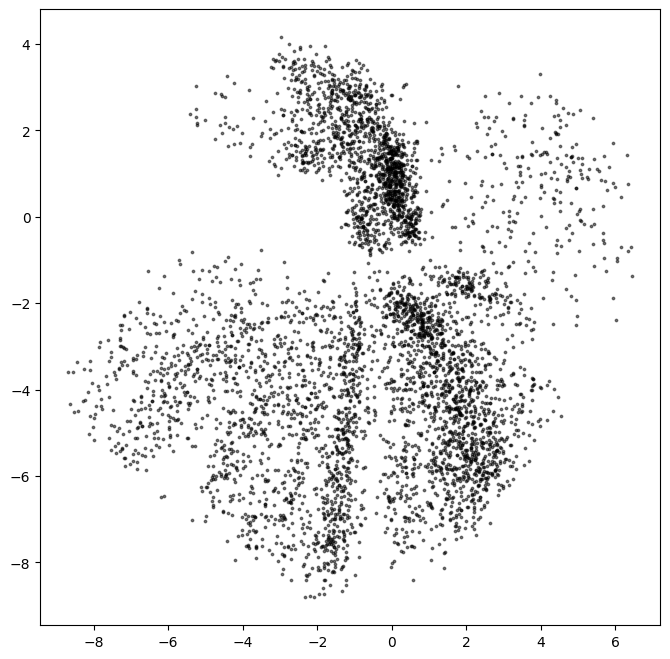

In [13]:
#Encode the image
embeddings = encoder.predict(example_images)

#Plot the latent space
#this is the pictures known in the data plotted after the 2 values given post encoding
plt.figure(figsize = (8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c = "black", alpha = .5, s = 3)
plt.show()

#each black dot represent an image in the latent space

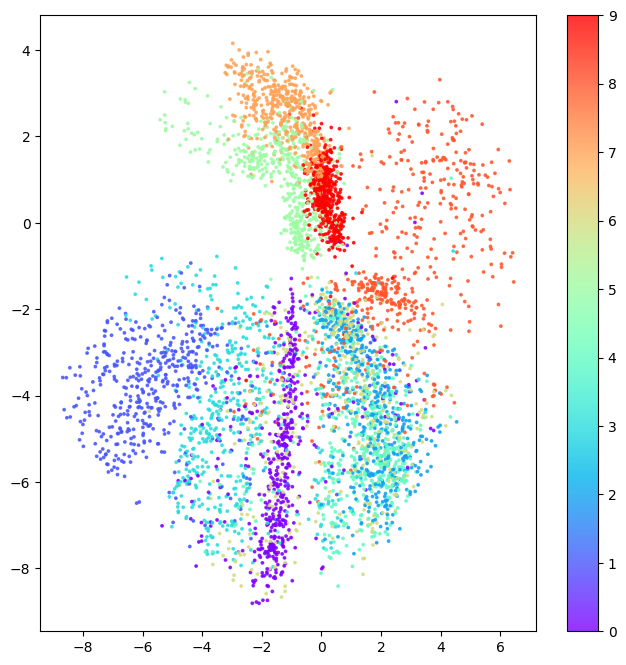

In [14]:
# Color the embeddings by their label
example_labels = y_test[:n_to_predict]

#graph size
figsize = 8

#create graph
plt.figure(figsize=(figsize, figsize))

#add scatter plot points
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)

#add a color bar to show the different type of cloths in latent space
plt.colorbar()
plt.show()

<h2>Generate Using The Decoder</h2>

In [15]:
#given the encoder position get the mins and maxs
mins, maxs = np.min(embeddings, axis = 0), np.max(embeddings, axis = 0)

#select random mins and maxes
sample = np.random.uniform(mins, maxs, size = (18, 2))

#set the grid dimensions
grid_width, grid_height = (6, 3)

#Decode the sampled points
reconstructions = decoder.predict(sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


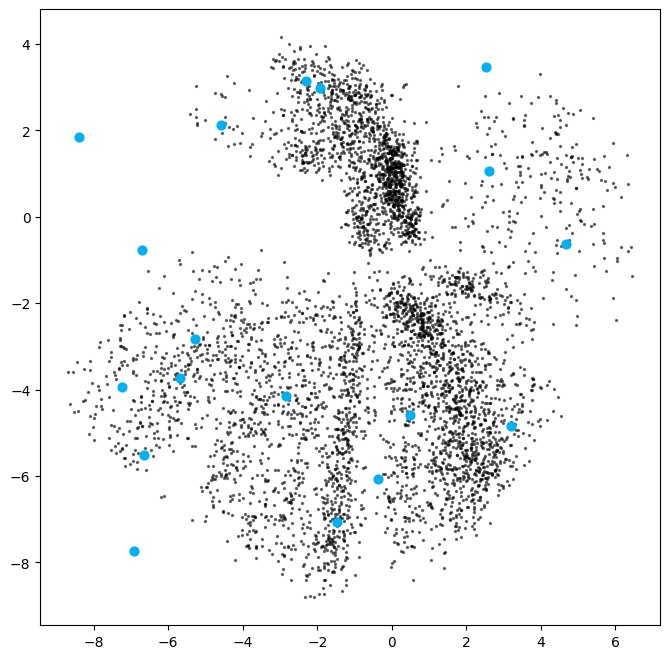

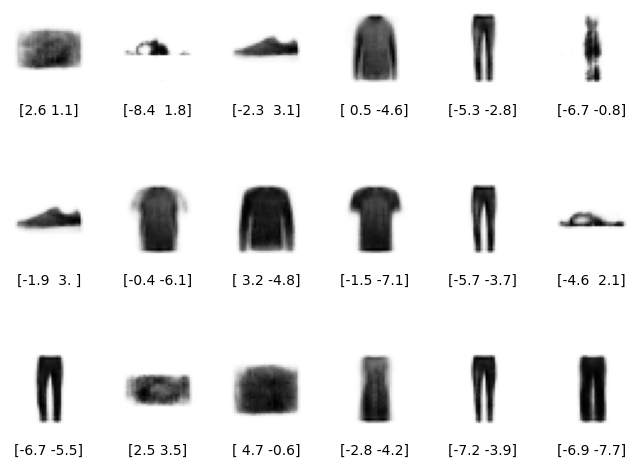

In [16]:
#recreate the encoder images
reconstruction = decoder.predict(sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#6*3 is the size of the grid
for i in range(6 * 3):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


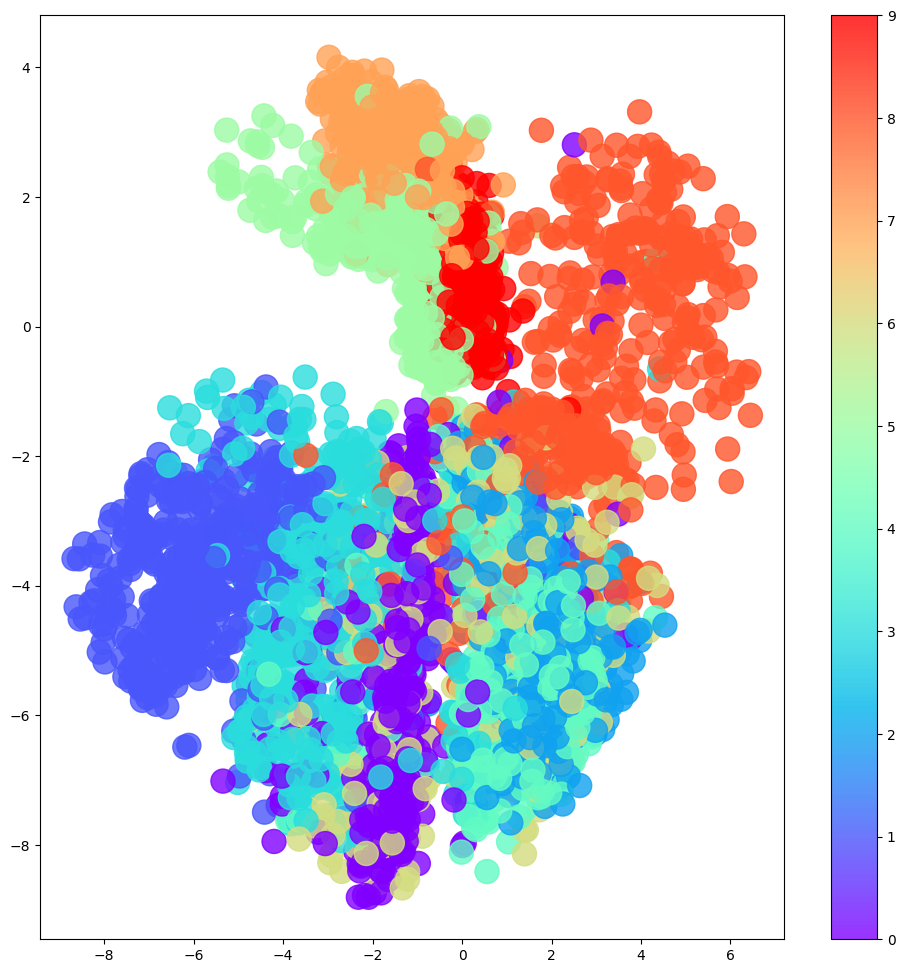

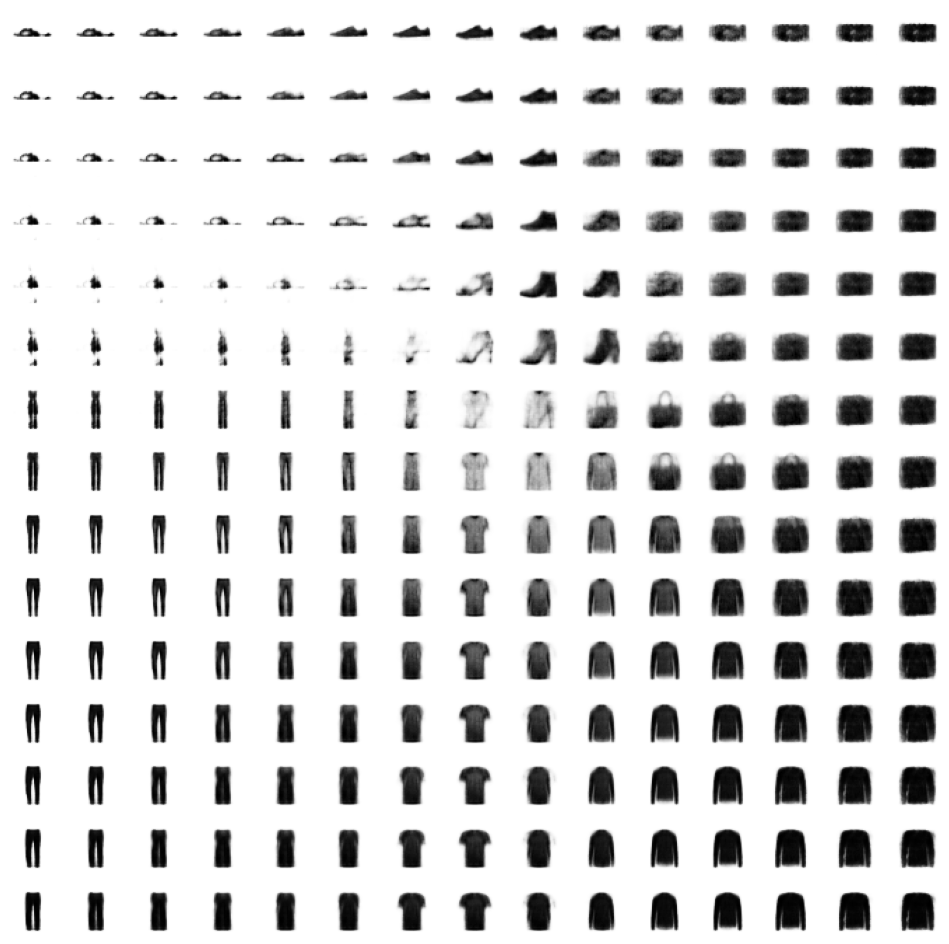

In [17]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
#plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()



#plot the images on the latent space
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

<h1>Variational AutoEncoders</h1>

<p>Add a subclass to the keras layers class</p>

In [18]:
#subclassing the keras base layer class to give the 
#sampling layer with the inputs being represented by
#z_mean and z_log_variance
class Sampling(layers.Layer): 
    def call(self, inputs):
        #get the mean and log varience
        z_mean, z_log_var = inputs

        #set the batch and dimesion
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        #calculate epsilon
        epsilon = tf.random.normal(shape=(batch, dim))

        #return mean + e^(.5 * log varience)* epsilon
        return z_mean + tf.exp(.5 *z_log_var) * epsilon

In [19]:
#recreate the encoder for a normal autoencoder
encoder_input = layers.Input( shape= (32, 32, 1), name = "encoder_input")

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = x.shape[1:]

x = layers.Flatten()(x)

#this part is what make the autoencoder a variational autoencoder
#to add more dimensions to the latent space for better image generation
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#set beta since a beta-VAE is used
BETA = 500
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        #set the class variables
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
    
    #return metrics
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [21]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [22]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [23]:
vae.fit(
    x_train,
    epochs= 5,
    batch_size= 100,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - kl_loss: 4.4782 - reconstruction_loss: 158.4510 - total_loss: 162.9292 - val_kl_loss: 5.2148 - val_loss: 138.2180 - val_reconstruction_loss: 133.0033
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - kl_loss: 5.1398 - reconstruction_loss: 128.6116 - total_loss: 133.7514 - val_kl_loss: 5.2711 - val_loss: 135.6234 - val_reconstruction_loss: 130.3523
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - kl_loss: 5.2208 - reconstruction_loss: 126.8760 - total_loss: 132.0968 - val_kl_loss: 5.2159 - val_loss: 134.7144 - val_reconstruction_loss: 129.4986
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - kl_loss: 5.2492 - reconstruction_loss: 126.3410 - total_loss: 131.5902 - val_kl_loss: 5.2581 - val_loss: 134.4614 - val_reconstruction_loss: 129.2033
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - kl_loss: 5.2788 - reconstruction_loss: 125.7165 - total_loss: 130.9953 - val_kl_loss: 5.5531 - val_loss: 134.3525 - val_recon

In [24]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
# Some examples of the embeddings
print(z[:10])

[[-0.06496312  1.0956935 ]
 [ 1.0554229  -1.4891815 ]
 [-2.3283212  -0.684928  ]
 [-1.6916107  -0.06492978]
 [ 0.6066376  -0.44698513]
 [-1.4009696  -0.7147168 ]
 [-0.22782534 -0.3091803 ]
 [ 0.32816705 -0.5012018 ]
 [-1.7444307   1.2281424 ]
 [-0.9787536   2.0132453 ]]


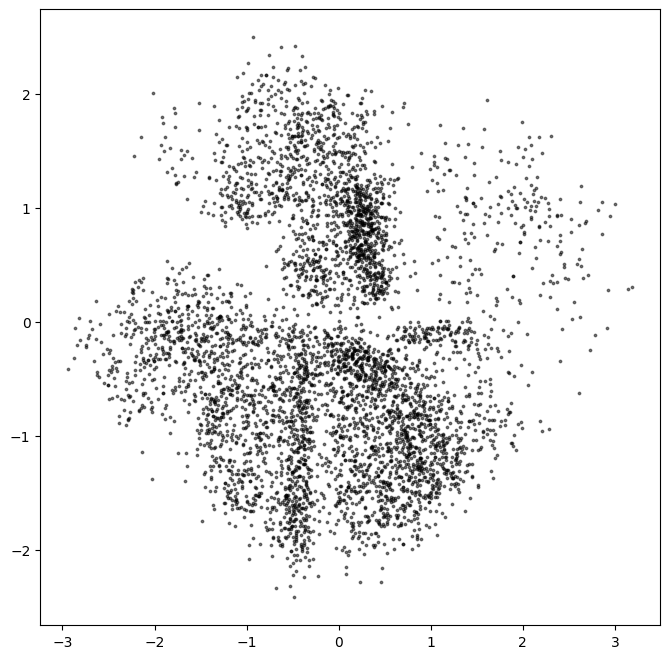

In [26]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [27]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


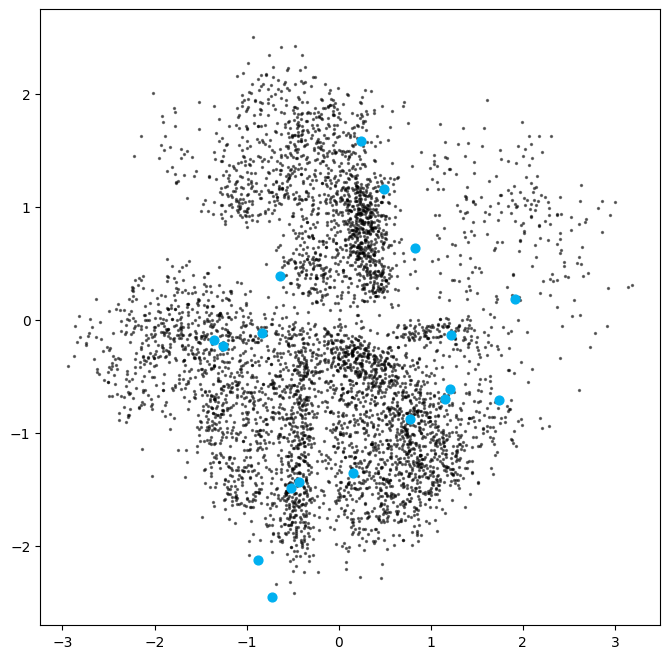

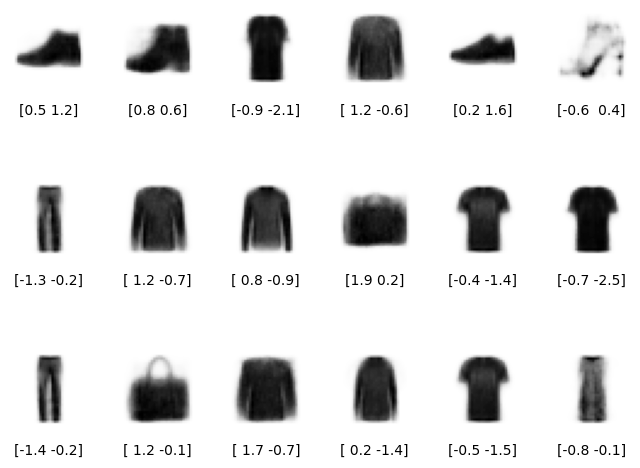

In [28]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

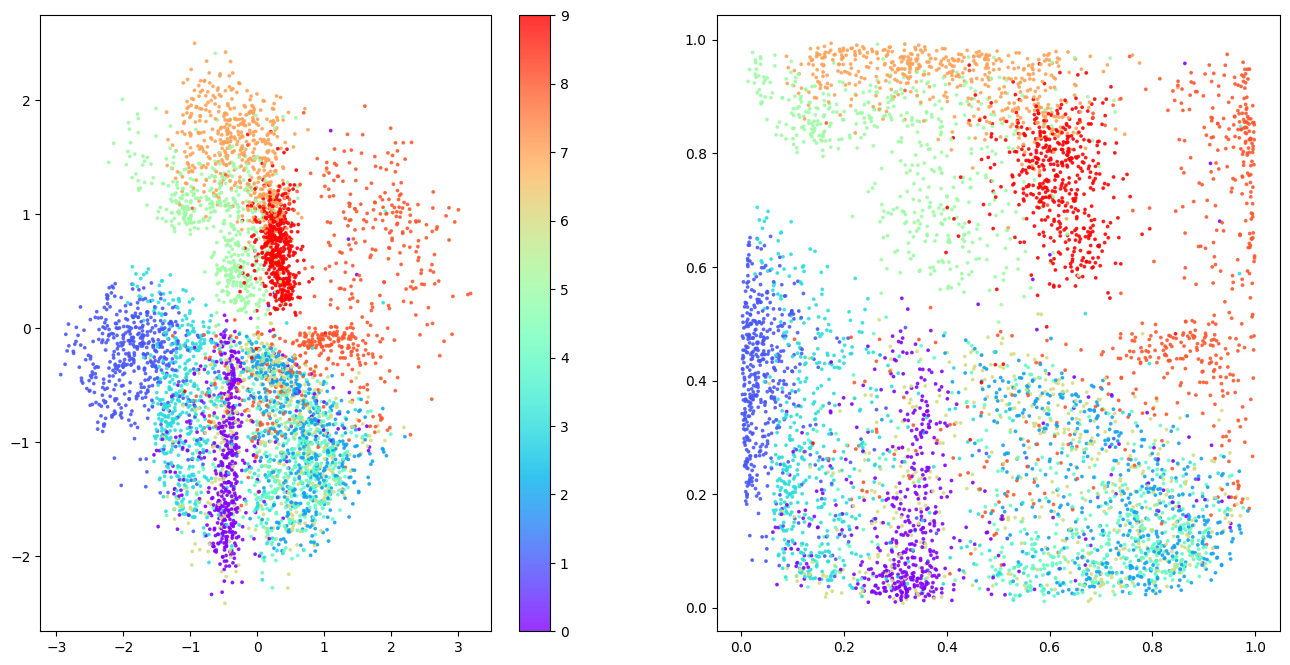

In [29]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


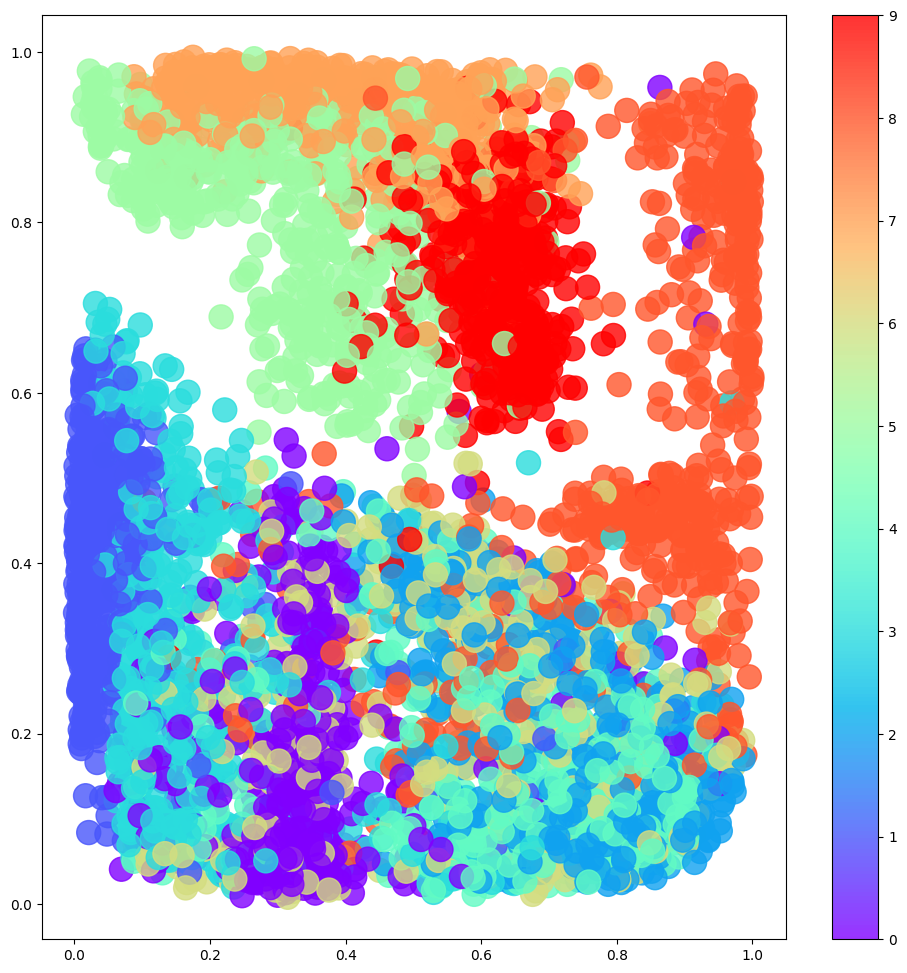

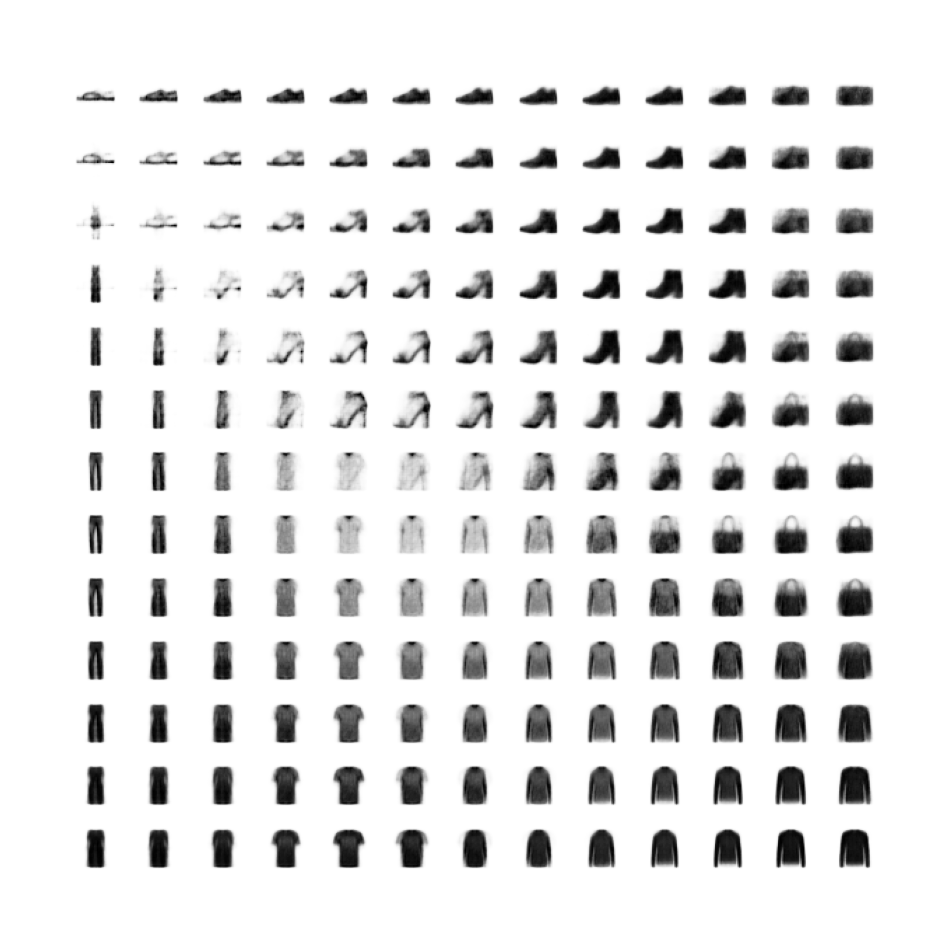

In [30]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")